In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1",
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 7000], examples_per_second: 436.3236, train_label_loss: 2.7911, 


epoch: 1, [batch: 700 / 7000], examples_per_second: 10547.8156, train_label_loss: 2.6469, 


epoch: 1, [batch: 1400 / 7000], examples_per_second: 10697.4081, train_label_loss: 2.6693, 


epoch: 1, [batch: 2100 / 7000], examples_per_second: 10646.0734, train_label_loss: 2.3393, 


epoch: 1, [batch: 2800 / 7000], examples_per_second: 10666.5951, train_label_loss: 2.2365, 


epoch: 1, [batch: 3500 / 7000], examples_per_second: 10602.9310, train_label_loss: 2.0886, 


epoch: 1, [batch: 4200 / 7000], examples_per_second: 10664.3704, train_label_loss: 1.6757, 


epoch: 1, [batch: 4900 / 7000], examples_per_second: 10633.4637, train_label_loss: 1.7202, 


epoch: 1, [batch: 5600 / 7000], examples_per_second: 10658.6880, train_label_loss: 1.7971, 


epoch: 1, [batch: 6300 / 7000], examples_per_second: 10636.6771, train_label_loss: 1.4778, 


epoch: 1, source_val_acc_label: 0.5797, source_val_label_loss: 1.2875, target_val_acc_label: 0.5797, target_val_label_loss: 1.2875, 


New best
epoch: 2, [batch: 1 / 7000], examples_per_second: 10.6183, train_label_loss: 1.2904, 


epoch: 2, [batch: 700 / 7000], examples_per_second: 10645.2668, train_label_loss: 1.2910, 


epoch: 2, [batch: 1400 / 7000], examples_per_second: 10605.9553, train_label_loss: 1.5205, 


epoch: 2, [batch: 2100 / 7000], examples_per_second: 10588.4619, train_label_loss: 1.1218, 


epoch: 2, [batch: 2800 / 7000], examples_per_second: 10617.7201, train_label_loss: 1.0829, 


epoch: 2, [batch: 3500 / 7000], examples_per_second: 11023.0229, train_label_loss: 1.3951, 


epoch: 2, [batch: 4200 / 7000], examples_per_second: 11655.7935, train_label_loss: 1.0059, 


epoch: 2, [batch: 4900 / 7000], examples_per_second: 11670.6265, train_label_loss: 1.0821, 


epoch: 2, [batch: 5600 / 7000], examples_per_second: 12073.7456, train_label_loss: 0.9982, 


epoch: 2, [batch: 6300 / 7000], examples_per_second: 12716.6078, train_label_loss: 0.8768, 


epoch: 2, source_val_acc_label: 0.6771, source_val_label_loss: 0.9443, target_val_acc_label: 0.6771, target_val_label_loss: 0.9443, 


New best
epoch: 3, [batch: 1 / 7000], examples_per_second: 14.6127, train_label_loss: 1.0314, 


epoch: 3, [batch: 700 / 7000], examples_per_second: 12813.8351, train_label_loss: 1.2895, 


epoch: 3, [batch: 1400 / 7000], examples_per_second: 13021.5165, train_label_loss: 0.8462, 


epoch: 3, [batch: 2100 / 7000], examples_per_second: 13086.5451, train_label_loss: 0.8646, 


epoch: 3, [batch: 2800 / 7000], examples_per_second: 11695.0457, train_label_loss: 0.7990, 


epoch: 3, [batch: 3500 / 7000], examples_per_second: 11973.9183, train_label_loss: 0.9772, 


epoch: 3, [batch: 4200 / 7000], examples_per_second: 11279.7949, train_label_loss: 0.7671, 


epoch: 3, [batch: 4900 / 7000], examples_per_second: 10567.1194, train_label_loss: 0.9748, 


epoch: 3, [batch: 5600 / 7000], examples_per_second: 10638.5436, train_label_loss: 0.8208, 


epoch: 3, [batch: 6300 / 7000], examples_per_second: 10645.3484, train_label_loss: 0.7230, 


epoch: 3, source_val_acc_label: 0.7079, source_val_label_loss: 0.8912, target_val_acc_label: 0.7079, target_val_label_loss: 0.8912, 


New best
epoch: 4, [batch: 1 / 7000], examples_per_second: 11.5624, train_label_loss: 0.6370, 


epoch: 4, [batch: 700 / 7000], examples_per_second: 10644.1411, train_label_loss: 0.6232, 


epoch: 4, [batch: 1400 / 7000], examples_per_second: 10610.6264, train_label_loss: 0.6471, 


epoch: 4, [batch: 2100 / 7000], examples_per_second: 10648.5144, train_label_loss: 1.0941, 


epoch: 4, [batch: 2800 / 7000], examples_per_second: 10599.2100, train_label_loss: 0.6512, 


epoch: 4, [batch: 3500 / 7000], examples_per_second: 10654.0409, train_label_loss: 0.4993, 


epoch: 4, [batch: 4200 / 7000], examples_per_second: 10720.0726, train_label_loss: 0.8300, 


epoch: 4, [batch: 4900 / 7000], examples_per_second: 10659.7437, train_label_loss: 0.5658, 


epoch: 4, [batch: 5600 / 7000], examples_per_second: 10658.6835, train_label_loss: 0.5911, 


epoch: 4, [batch: 6300 / 7000], examples_per_second: 10657.7664, train_label_loss: 0.5968, 


epoch: 4, source_val_acc_label: 0.7660, source_val_label_loss: 0.6567, target_val_acc_label: 0.7660, target_val_label_loss: 0.6567, 


New best
epoch: 5, [batch: 1 / 7000], examples_per_second: 11.5030, train_label_loss: 0.4497, 


epoch: 5, [batch: 700 / 7000], examples_per_second: 10689.6799, train_label_loss: 0.4624, 


epoch: 5, [batch: 1400 / 7000], examples_per_second: 10667.3442, train_label_loss: 0.6553, 


epoch: 5, [batch: 2100 / 7000], examples_per_second: 10694.6646, train_label_loss: 0.4713, 


epoch: 5, [batch: 2800 / 7000], examples_per_second: 10723.1372, train_label_loss: 0.4407, 


epoch: 5, [batch: 3500 / 7000], examples_per_second: 10685.3625, train_label_loss: 0.6568, 


epoch: 5, [batch: 4200 / 7000], examples_per_second: 10708.2136, train_label_loss: 0.3994, 


epoch: 5, [batch: 4900 / 7000], examples_per_second: 10728.1078, train_label_loss: 0.5302, 


epoch: 5, [batch: 5600 / 7000], examples_per_second: 10710.4390, train_label_loss: 0.5226, 


epoch: 5, [batch: 6300 / 7000], examples_per_second: 10676.8552, train_label_loss: 0.5223, 


epoch: 5, source_val_acc_label: 0.7327, source_val_label_loss: 0.7456, target_val_acc_label: 0.7327, target_val_label_loss: 0.7456, 


epoch: 6, [batch: 1 / 7000], examples_per_second: 11.4507, train_label_loss: 0.4420, 


epoch: 6, [batch: 700 / 7000], examples_per_second: 10688.9744, train_label_loss: 0.5440, 


epoch: 6, [batch: 1400 / 7000], examples_per_second: 10656.1499, train_label_loss: 0.4981, 


epoch: 6, [batch: 2100 / 7000], examples_per_second: 10699.2391, train_label_loss: 0.7142, 


epoch: 6, [batch: 2800 / 7000], examples_per_second: 11087.3548, train_label_loss: 0.5103, 


epoch: 6, [batch: 3500 / 7000], examples_per_second: 11725.4795, train_label_loss: 0.4921, 


epoch: 6, [batch: 4200 / 7000], examples_per_second: 11707.1911, train_label_loss: 0.6654, 


epoch: 6, [batch: 4900 / 7000], examples_per_second: 12189.4274, train_label_loss: 0.5634, 


epoch: 6, [batch: 5600 / 7000], examples_per_second: 13049.9630, train_label_loss: 0.4194, 


epoch: 6, [batch: 6300 / 7000], examples_per_second: 13135.7411, train_label_loss: 0.5116, 


epoch: 6, source_val_acc_label: 0.7670, source_val_label_loss: 0.6355, target_val_acc_label: 0.7670, target_val_label_loss: 0.6355, 


New best
epoch: 7, [batch: 1 / 7000], examples_per_second: 14.8414, train_label_loss: 0.6052, 


epoch: 7, [batch: 700 / 7000], examples_per_second: 12940.7343, train_label_loss: 0.7283, 


epoch: 7, [batch: 1400 / 7000], examples_per_second: 13766.6419, train_label_loss: 0.3035, 


epoch: 7, [batch: 2100 / 7000], examples_per_second: 11963.8050, train_label_loss: 0.7693, 


epoch: 7, [batch: 2800 / 7000], examples_per_second: 11755.6173, train_label_loss: 0.4152, 


epoch: 7, [batch: 3500 / 7000], examples_per_second: 12304.3324, train_label_loss: 0.3712, 


epoch: 7, [batch: 4200 / 7000], examples_per_second: 10703.8949, train_label_loss: 0.4701, 


epoch: 7, [batch: 4900 / 7000], examples_per_second: 10717.6506, train_label_loss: 0.4349, 


epoch: 7, [batch: 5600 / 7000], examples_per_second: 10718.5346, train_label_loss: 0.6205, 


epoch: 7, [batch: 6300 / 7000], examples_per_second: 10709.5630, train_label_loss: 0.3479, 


epoch: 7, source_val_acc_label: 0.7739, source_val_label_loss: 0.6174, target_val_acc_label: 0.7739, target_val_label_loss: 0.6174, 


New best
epoch: 8, [batch: 1 / 7000], examples_per_second: 11.5585, train_label_loss: 0.2748, 


epoch: 8, [batch: 700 / 7000], examples_per_second: 10718.5077, train_label_loss: 0.5797, 


epoch: 8, [batch: 1400 / 7000], examples_per_second: 10738.9533, train_label_loss: 0.3123, 


epoch: 8, [batch: 2100 / 7000], examples_per_second: 10736.2489, train_label_loss: 0.4844, 


epoch: 8, [batch: 2800 / 7000], examples_per_second: 10718.6860, train_label_loss: 0.3846, 


epoch: 8, [batch: 3500 / 7000], examples_per_second: 10715.9847, train_label_loss: 0.4503, 


epoch: 8, [batch: 4200 / 7000], examples_per_second: 10746.8773, train_label_loss: 0.3507, 


epoch: 8, [batch: 4900 / 7000], examples_per_second: 10722.7134, train_label_loss: 0.5708, 


epoch: 8, [batch: 5600 / 7000], examples_per_second: 10686.9010, train_label_loss: 0.4680, 


epoch: 8, [batch: 6300 / 7000], examples_per_second: 10730.6215, train_label_loss: 0.4201, 


epoch: 8, source_val_acc_label: 0.7758, source_val_label_loss: 0.6360, target_val_acc_label: 0.7758, target_val_label_loss: 0.6360, 


New best
epoch: 9, [batch: 1 / 7000], examples_per_second: 11.4293, train_label_loss: 0.2970, 


epoch: 9, [batch: 700 / 7000], examples_per_second: 10668.0594, train_label_loss: 0.1927, 


epoch: 9, [batch: 1400 / 7000], examples_per_second: 10695.3163, train_label_loss: 0.3254, 


epoch: 9, [batch: 2100 / 7000], examples_per_second: 10777.7201, train_label_loss: 0.3800, 


epoch: 9, [batch: 2800 / 7000], examples_per_second: 10686.8149, train_label_loss: 0.5604, 


epoch: 9, [batch: 3500 / 7000], examples_per_second: 10694.8896, train_label_loss: 0.4862, 


epoch: 9, [batch: 4200 / 7000], examples_per_second: 10695.1480, train_label_loss: 0.3130, 


epoch: 9, [batch: 4900 / 7000], examples_per_second: 10655.5516, train_label_loss: 0.4364, 


epoch: 9, [batch: 5600 / 7000], examples_per_second: 10709.5453, train_label_loss: 0.9204, 


epoch: 9, [batch: 6300 / 7000], examples_per_second: 10667.1731, train_label_loss: 0.6237, 


epoch: 9, source_val_acc_label: 0.7716, source_val_label_loss: 0.6702, target_val_acc_label: 0.7716, target_val_label_loss: 0.6702, 


epoch: 10, [batch: 1 / 7000], examples_per_second: 11.5274, train_label_loss: 0.3091, 


epoch: 10, [batch: 700 / 7000], examples_per_second: 10707.4677, train_label_loss: 0.2585, 


epoch: 10, [batch: 1400 / 7000], examples_per_second: 10694.1923, train_label_loss: 0.4984, 


epoch: 10, [batch: 2100 / 7000], examples_per_second: 10689.1762, train_label_loss: 0.3505, 


epoch: 10, [batch: 2800 / 7000], examples_per_second: 11480.5068, train_label_loss: 0.4471, 


epoch: 10, [batch: 3500 / 7000], examples_per_second: 11689.1978, train_label_loss: 0.2520, 


epoch: 10, [batch: 4200 / 7000], examples_per_second: 11752.6354, train_label_loss: 0.3846, 


epoch: 10, [batch: 4900 / 7000], examples_per_second: 12439.4289, train_label_loss: 0.6444, 


epoch: 10, [batch: 5600 / 7000], examples_per_second: 12936.2450, train_label_loss: 0.3937, 


epoch: 10, [batch: 6300 / 7000], examples_per_second: 13134.0278, train_label_loss: 0.3047, 


epoch: 10, source_val_acc_label: 0.7533, source_val_label_loss: 0.7112, target_val_acc_label: 0.7533, target_val_label_loss: 0.7112, 


epoch: 11, [batch: 1 / 7000], examples_per_second: 14.9045, train_label_loss: 0.3125, 


epoch: 11, [batch: 700 / 7000], examples_per_second: 13073.1043, train_label_loss: 0.3212, 


epoch: 11, [batch: 1400 / 7000], examples_per_second: 13275.5722, train_label_loss: 0.3363, 


epoch: 11, [batch: 2100 / 7000], examples_per_second: 11810.6103, train_label_loss: 0.2690, 


epoch: 11, [batch: 2800 / 7000], examples_per_second: 11748.1388, train_label_loss: 0.3496, 


epoch: 11, [batch: 3500 / 7000], examples_per_second: 12083.1369, train_label_loss: 0.2568, 


epoch: 11, [batch: 4200 / 7000], examples_per_second: 10741.3505, train_label_loss: 0.3057, 


epoch: 11, [batch: 4900 / 7000], examples_per_second: 10669.6359, train_label_loss: 0.2867, 


epoch: 11, [batch: 5600 / 7000], examples_per_second: 10738.4586, train_label_loss: 0.5877, 


epoch: 11, [batch: 6300 / 7000], examples_per_second: 10696.6472, train_label_loss: 0.3924, 


epoch: 11, source_val_acc_label: 0.7773, source_val_label_loss: 0.6354, target_val_acc_label: 0.7773, target_val_label_loss: 0.6354, 


New best
epoch: 12, [batch: 1 / 7000], examples_per_second: 11.4865, train_label_loss: 0.2065, 


epoch: 12, [batch: 700 / 7000], examples_per_second: 10717.3974, train_label_loss: 0.2708, 


epoch: 12, [batch: 1400 / 7000], examples_per_second: 10699.2680, train_label_loss: 0.1767, 


epoch: 12, [batch: 2100 / 7000], examples_per_second: 10758.7661, train_label_loss: 0.1983, 


epoch: 12, [batch: 2800 / 7000], examples_per_second: 10707.5591, train_label_loss: 0.3248, 


epoch: 12, [batch: 3500 / 7000], examples_per_second: 10675.6034, train_label_loss: 0.2608, 


epoch: 12, [batch: 4200 / 7000], examples_per_second: 10726.9800, train_label_loss: 0.2769, 


epoch: 12, [batch: 4900 / 7000], examples_per_second: 10695.1215, train_label_loss: 0.2412, 


epoch: 12, [batch: 5600 / 7000], examples_per_second: 10689.9463, train_label_loss: 0.6084, 


epoch: 12, [batch: 6300 / 7000], examples_per_second: 10692.2654, train_label_loss: 0.3712, 


epoch: 12, source_val_acc_label: 0.7662, source_val_label_loss: 0.6759, target_val_acc_label: 0.7662, target_val_label_loss: 0.6759, 


epoch: 13, [batch: 1 / 7000], examples_per_second: 11.4616, train_label_loss: 0.1696, 


epoch: 13, [batch: 700 / 7000], examples_per_second: 10702.3092, train_label_loss: 0.1841, 


epoch: 13, [batch: 1400 / 7000], examples_per_second: 10696.8302, train_label_loss: 0.4167, 


epoch: 13, [batch: 2100 / 7000], examples_per_second: 10699.6000, train_label_loss: 0.2329, 


epoch: 13, [batch: 2800 / 7000], examples_per_second: 10683.6766, train_label_loss: 0.2529, 


epoch: 13, [batch: 3500 / 7000], examples_per_second: 10703.6501, train_label_loss: 0.4316, 


epoch: 13, [batch: 4200 / 7000], examples_per_second: 10704.5223, train_label_loss: 0.3195, 


epoch: 13, [batch: 4900 / 7000], examples_per_second: 10701.1365, train_label_loss: 0.2720, 


epoch: 13, [batch: 5600 / 7000], examples_per_second: 10675.4336, train_label_loss: 0.2775, 


epoch: 13, [batch: 6300 / 7000], examples_per_second: 10687.1009, train_label_loss: 0.2984, 


epoch: 13, source_val_acc_label: 0.7685, source_val_label_loss: 0.6789, target_val_acc_label: 0.7685, target_val_label_loss: 0.6789, 


epoch: 14, [batch: 1 / 7000], examples_per_second: 11.4545, train_label_loss: 0.1922, 


epoch: 14, [batch: 700 / 7000], examples_per_second: 10747.7259, train_label_loss: 0.1645, 


epoch: 14, [batch: 1400 / 7000], examples_per_second: 10682.0771, train_label_loss: 0.3038, 


epoch: 14, [batch: 2100 / 7000], examples_per_second: 10895.2986, train_label_loss: 0.1417, 


epoch: 14, [batch: 2800 / 7000], examples_per_second: 11761.3238, train_label_loss: 0.1563, 


epoch: 14, [batch: 3500 / 7000], examples_per_second: 11738.6841, train_label_loss: 0.2981, 


epoch: 14, [batch: 4200 / 7000], examples_per_second: 11699.8718, train_label_loss: 0.4129, 


epoch: 14, [batch: 4900 / 7000], examples_per_second: 12933.2173, train_label_loss: 0.3561, 


epoch: 14, [batch: 5600 / 7000], examples_per_second: 12916.9782, train_label_loss: 0.3743, 


epoch: 14, [batch: 6300 / 7000], examples_per_second: 13117.7140, train_label_loss: 0.2315, 


epoch: 14, source_val_acc_label: 0.7735, source_val_label_loss: 0.6805, target_val_acc_label: 0.7735, target_val_label_loss: 0.6805, 


epoch: 15, [batch: 1 / 7000], examples_per_second: 14.8888, train_label_loss: 0.3183, 


epoch: 15, [batch: 700 / 7000], examples_per_second: 13194.2466, train_label_loss: 0.2183, 


epoch: 15, [batch: 1400 / 7000], examples_per_second: 13047.3738, train_label_loss: 0.4372, 


epoch: 15, [batch: 2100 / 7000], examples_per_second: 12994.1282, train_label_loss: 0.2826, 


epoch: 15, [batch: 2800 / 7000], examples_per_second: 13057.6209, train_label_loss: 0.2021, 


epoch: 15, [batch: 3500 / 7000], examples_per_second: 13554.8060, train_label_loss: 0.2536, 


epoch: 15, [batch: 4200 / 7000], examples_per_second: 11802.8867, train_label_loss: 0.1369, 


epoch: 15, [batch: 4900 / 7000], examples_per_second: 11725.5384, train_label_loss: 0.1924, 


epoch: 15, [batch: 5600 / 7000], examples_per_second: 11693.7309, train_label_loss: 0.2053, 


epoch: 15, [batch: 6300 / 7000], examples_per_second: 11727.1436, train_label_loss: 0.2343, 


epoch: 15, source_val_acc_label: 0.7650, source_val_label_loss: 0.7090, target_val_acc_label: 0.7650, target_val_label_loss: 0.7090, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

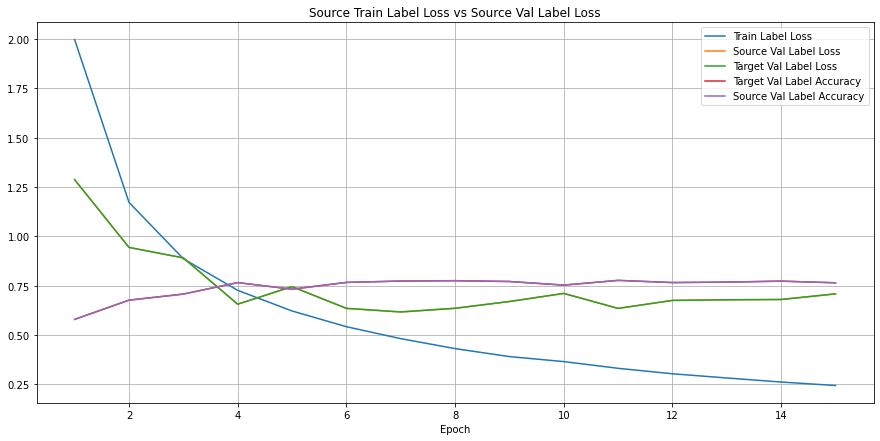

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

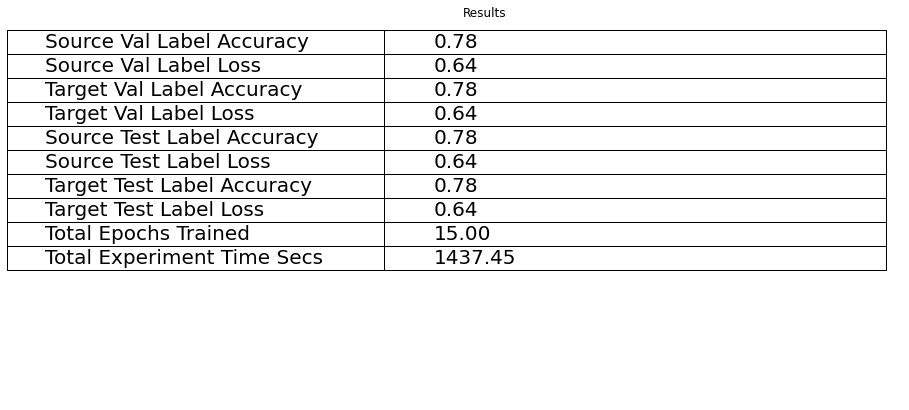

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

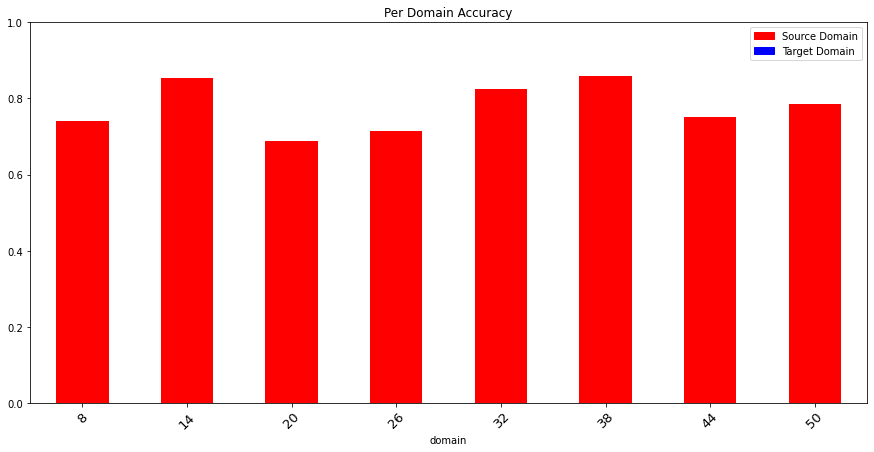

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.7755989583333334 Target Test Label Accuracy: 0.7755989583333334
Source Val Label Accuracy: 0.777296875 Target Val Label Accuracy: 0.777296875


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1", "parameters": {"experiment_name": "cnn_2:oracle.run1", "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [